In [ ]:
!pip install gensim == 4.1.2

In [1]:
import math
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# Load Data

In [2]:
# Use the unprocessed raw data. both spikes and locations measured at 20ms. 
# One should be able to replicate all rat2192 feat and pos files from these sources
raw_spikes = pd.read_csv("https://drive.google.com/uc?id=1-IuXanc2RZICrzqEG7jTg7f_AN9K9Ufl&export=download",
                         header=None)
raw_loc = pd.read_csv("https://drive.google.com/uc?id=1-XHfaaYkfNeQHYefY4uGX4r1q3AKGbic&export=download", header=None)


In [3]:
NEURONS_LIST = raw_spikes.columns.tolist()
NUM_NEURONS = len(NEURONS_LIST)

In [4]:
raw_loc.columns = ["x", "y"]
combined_data = pd.concat([raw_spikes, raw_loc], axis=1)

combined_data

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,x,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.638692,50.011963
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,51.620670,50.039728
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.619204,50.092329
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.640303,50.105809
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.673819,50.116286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,62.967008,73.292313
54096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,62.967008,73.292313
54097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,62.967008,73.292313
54098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,62.967008,73.292313


# Preprocessing (window length, size and skip)

In [6]:
def get_windows(df_len, window_len=10, window_hop=10, skip=0):
  num_windows = math.ceil((df_len - skip) / window_hop)
  answer = []
  for i in range(num_windows):
    start = skip + i * window_hop
    end = min(start + window_len, df_len - 1)
    mid = math.floor((start + end) / 2)
    answer.append((start, end, mid))

  return answer


def get_locations(df, window_len=10, window_hop=10, skip=0):
  idx = [False] * len(df)
  for w in get_windows(len(df), window_len, window_hop, skip):
    mid = w[2]
    idx[mid - 1] = True

  return df[idx]


def build_sentences(df, window_len=10, window_hop=10, skip=0, max_empty_words=2, word_ordering="shuffle"):
  """
  builds sentence vectors from spiking data
  window_len: how many spiking timesteps are used for one sentence
  window_hop: how much to slide the window. if window_len==window_hop there is no overlap. if hop<len, there is overlap.
  max_empty_words: how many consecutive empty words ("_") to keep. if 0, they are removed alltogether. if -1, keep all of them
  word_ordering: "shuffle" or "sort". If several neurons spike in one timestep, how to order them. If the same set of neurons spiked, maybe we should have consistent ordering?
  skip: how many timesteps to skip from the beginning. maybe the rat is training at first and we should discard that data?
  """

  sents = []
  for w in get_windows(len(df), window_len, window_hop, skip):
    start, end, mid = w

    # process one sentence
    sent_words = []
    empty_seq_len = 0
    for j in range(start, end):
      row = df.iloc[j]

      if np.sum(row) == 0:
        empty_seq_len += 1

        if max_empty_words == -1 or max_empty_words >= empty_seq_len:
          sent_words.append("_")

      else:
        empty_seq_len = 0

        one_spike = row[row == 1].index.tolist()
        two_spikes = row[row == 2].index.tolist()
        three_spikes = row[row == 3].index.tolist()
        four_spikes = row[row == 4].index.tolist()
        word = 4 * four_spikes + 3 * three_spikes + 2 * two_spikes + one_spike

        if word_ordering == "shuffle":
          shuffle(word)
        else:
          word.sort()

        sent_words += word

    if len(sent_words) == 0:
      sent_words = ["_"]

    sents.append(sent_words)

  return sents

# Word2Vec


In [7]:
def train_word2vec(sents, vector_len=250, train_size=0.8, window_size=5, sg=0):
  model = Word2Vec(min_count=1, vector_size=vector_len, window=window_size, max_vocab_size=None, max_final_vocab=None,
                   sg=sg, compute_loss=True)
  train_test_boundary = math.floor(len(sents) * train_size)
  train_sents = sents[:train_test_boundary]

  model.build_vocab(train_sents)
  model.train(corpus_iterable=train_sents, total_examples=len(train_sents), epochs=20, compute_loss=True)

  return model

# Similar Neurons

Spiking overview of all neurons

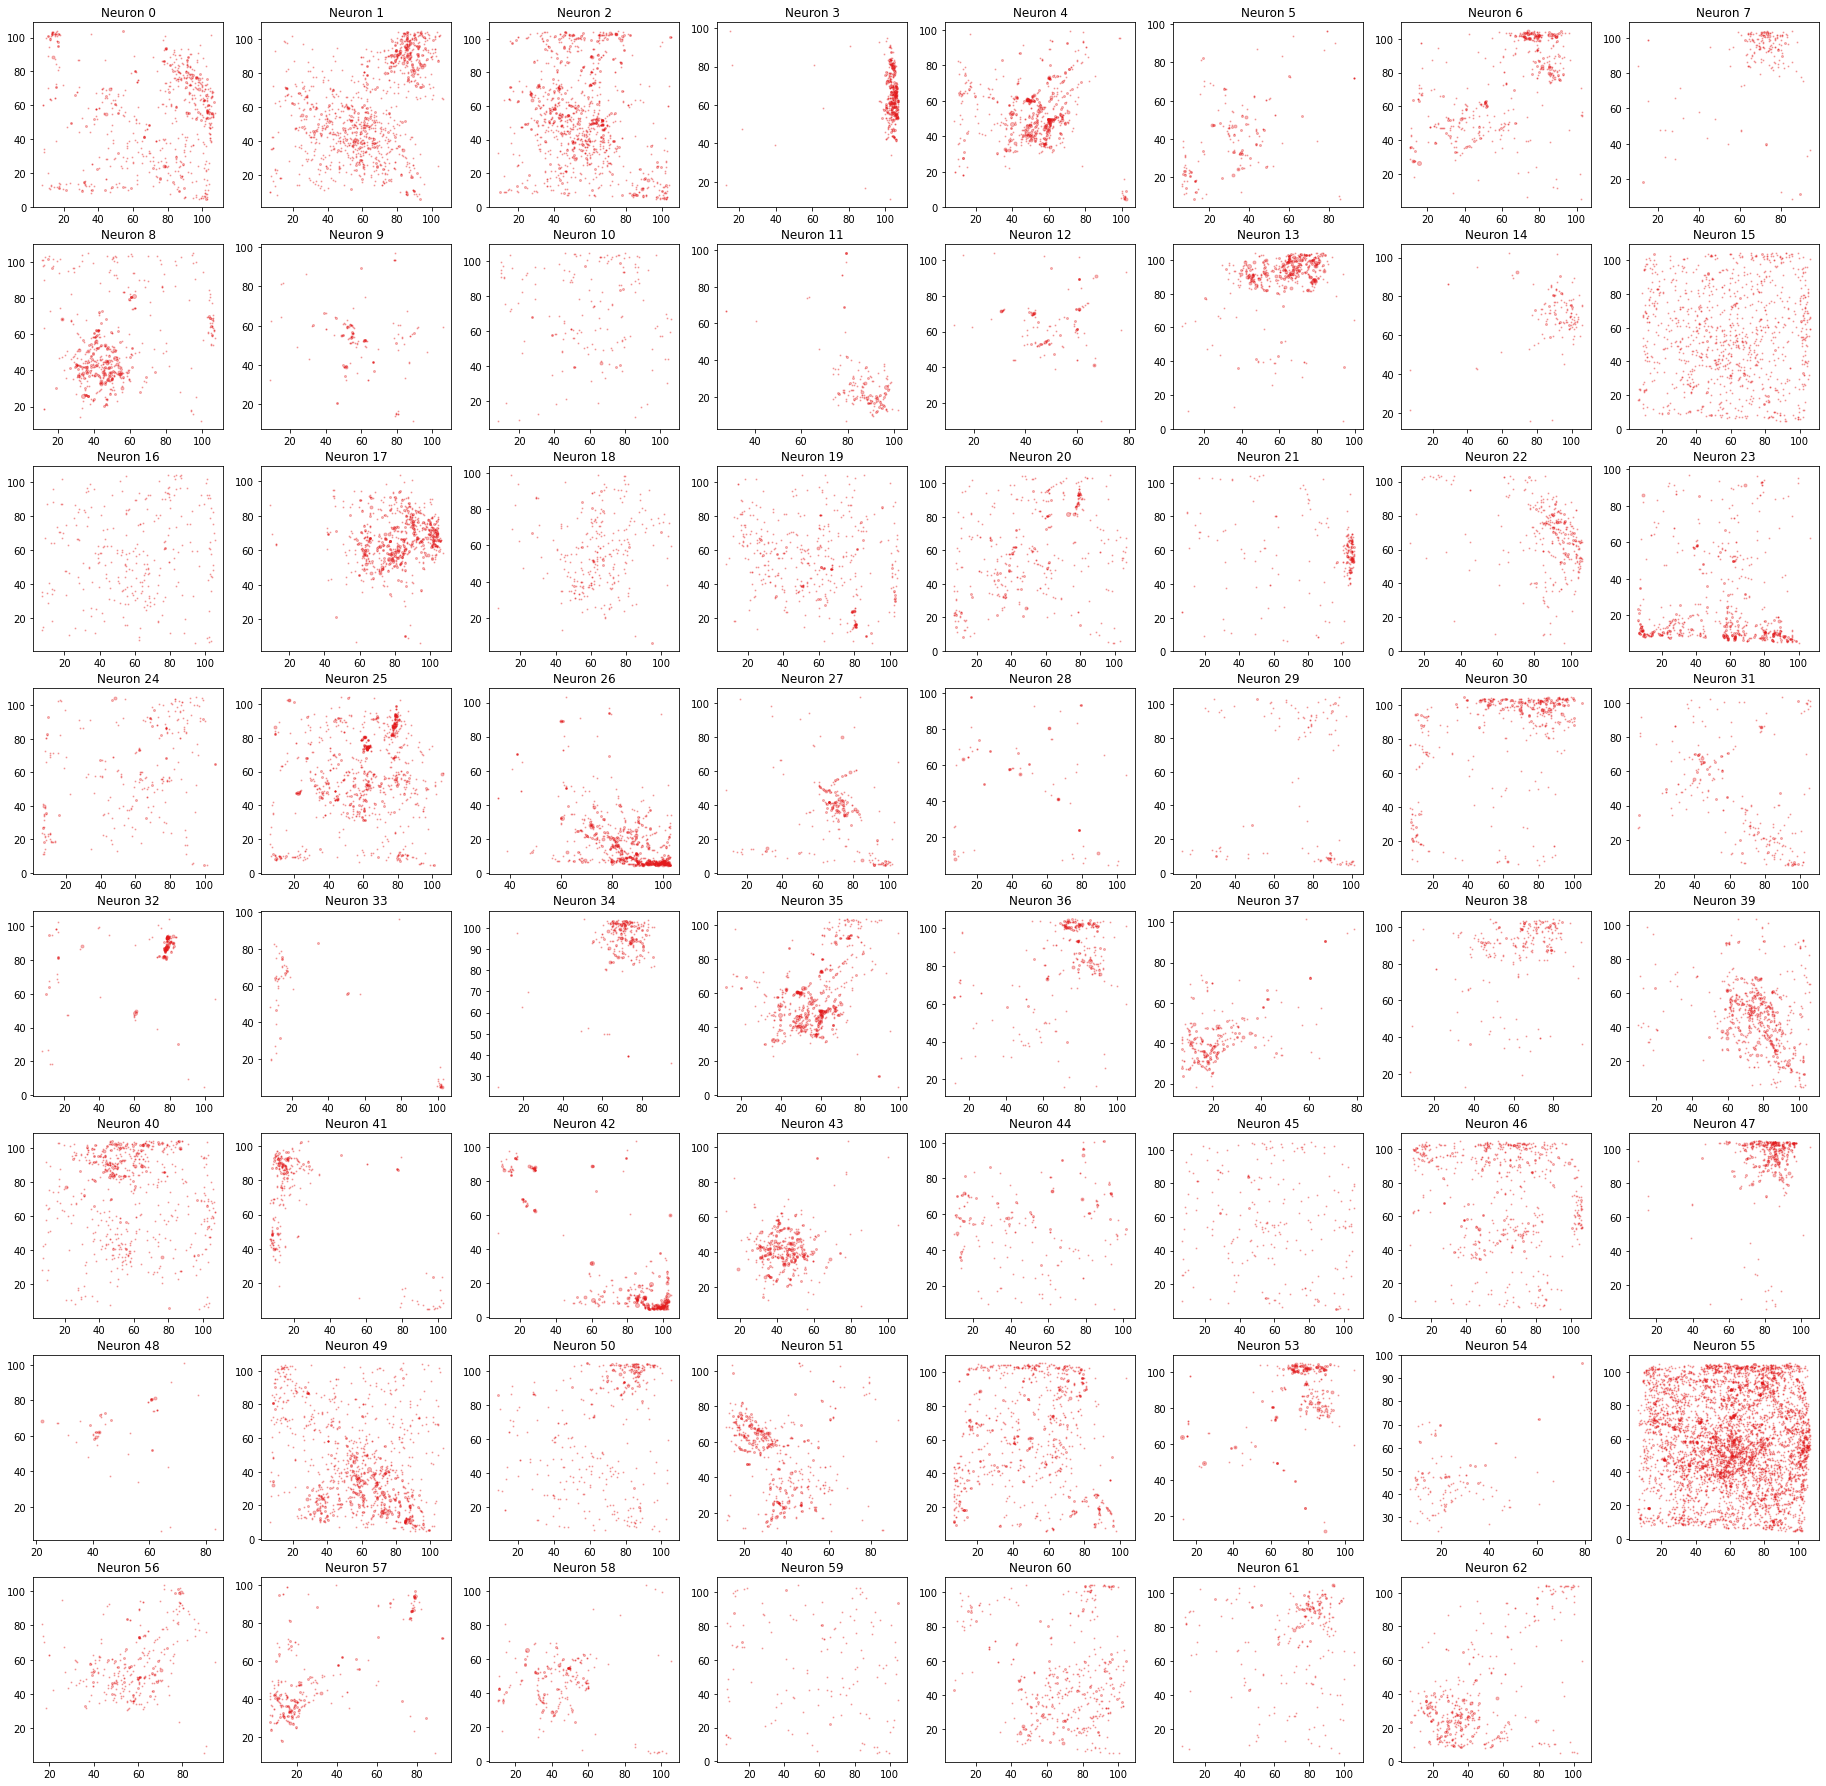

In [16]:
def print_all_neurons(spiking_df):
  edge_size = math.ceil(math.sqrt(NUM_NEURONS))  # 63 neurons -> 8x8
  plt.rcParams['figure.figsize'] = (edge_size * 4, edge_size * 4)

  for neuron in range(NUM_NEURONS):
    plt.subplot(edge_size, edge_size, neuron + 1)
    plt.title(f"Neuron {neuron}")
    non_empty = spiking_df[spiking_df[neuron] > 0]
    for _, row in non_empty.iterrows():
      x0, y0 = row[["x", "y"]]
      num_spikes = row[neuron]
      plt.plot([x0], [y0], '.', markersize=num_spikes * 2, color="#e31a1c", alpha=0.3)


print_all_neurons(combined_data)

Word2Vec Similarity

In [8]:
sents = build_sentences(raw_spikes)
wordvecs = train_word2vec(sents)

In [27]:
def build_similarity_dfs_for_top_n_neurons(wordvecs, top_n):
  similar_neurons = []
  similarities = []
  for neuron in range(NUM_NEURONS):
    sims = wordvecs.wv.most_similar([neuron], topn=top_n)
    similar_neurons.append([neuron_id for neuron_id, similarity in sims])
    similarities.append([similarity for neuron_id, similarity in sims])

  similar_neurons_df = pd.DataFrame(data=similar_neurons).T
  similarity_scores_df = pd.DataFrame(data=similarities).T

  return similar_neurons_df, similarity_scores_df

In [28]:
def plot_most_similar(neuron_id, wordvecs, spiking_and_loc_df, top_n=5):
  similar_df, similarities_df = build_similarity_dfs_for_top_n_neurons(wordvecs, top_n)

  neurons_list = [neuron_id] + similar_df[neuron_id].tolist()

  rows, cols = 1, len(neurons_list)
  plt.rcParams['figure.figsize'] = (cols * 4, rows * 4)

  for i, neuron in enumerate(neurons_list):
    plt.subplot(rows, cols, i + 1)

    if i == 0:
      plt.title(f"neuron {neuron}")
    else:
      plt.title(f"SIM {i}: neuron {neuron} ({round(similarities_df.iloc[i - 1, neuron_id], 3)})")

    if neuron != "_":
      non_empty = spiking_and_loc_df[spiking_and_loc_df[neuron] > 0]
      for _, row in non_empty.iterrows():
        x0, y0 = row[["x", "y"]]
        num_spikes = row[neuron]
        plt.plot([x0], [y0], '.', markersize=num_spikes * 2, color="#e31a1c", alpha=0.3)


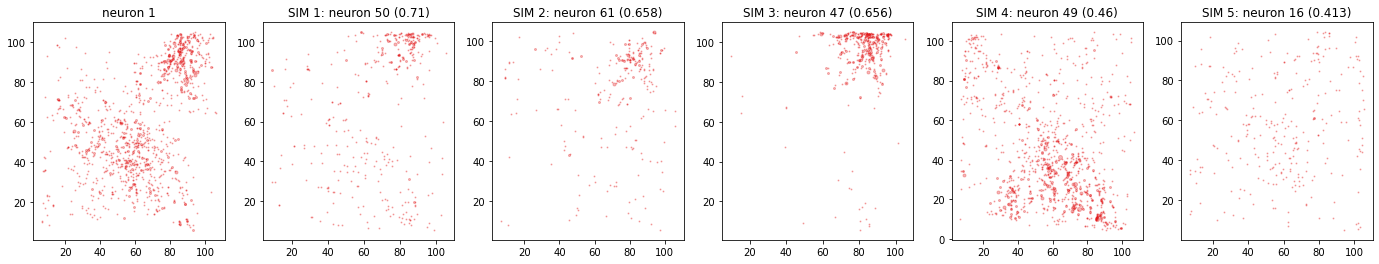

In [29]:
plot_most_similar(1, wordvecs, combined_data)

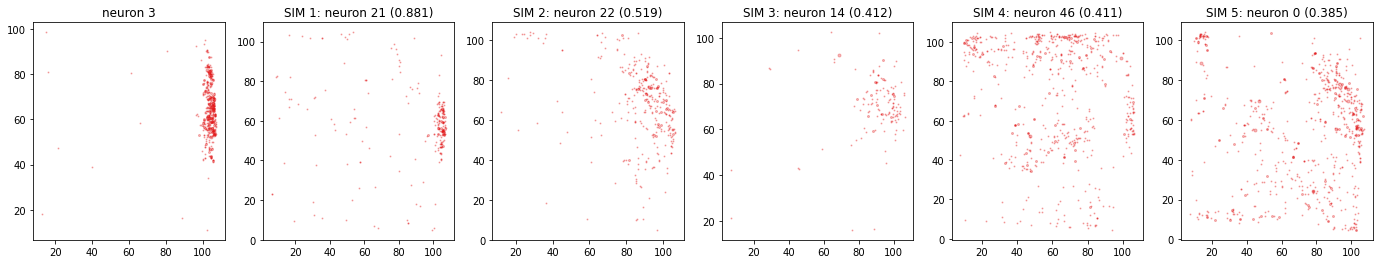

In [30]:
plot_most_similar(3, wordvecs, combined_data)

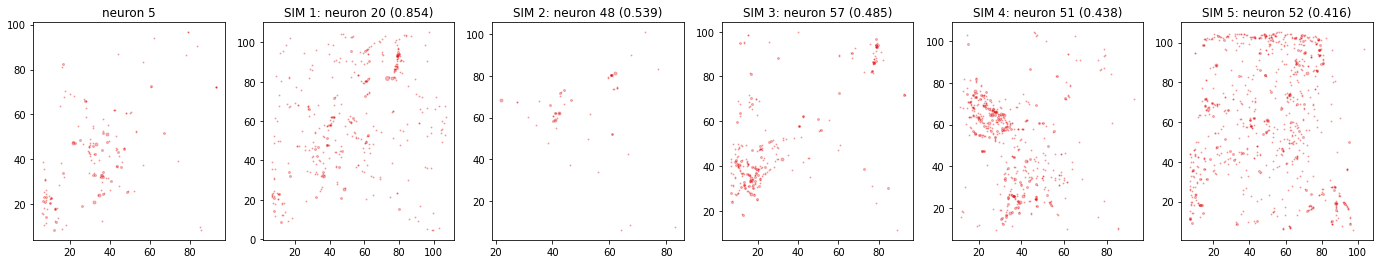

In [31]:
plot_most_similar(5, wordvecs, combined_data)

# Classification

In [33]:
def build_features(word2vec_model, sents, method="mean"):
  features = []
  for sent in sents:
    vecs = np.array([word2vec_model.wv[word] for word in sent])
    if method == "mean":
      features.append(np.mean(vecs, axis=0))
    else:
      # concatenate instead
      features.append(vecs.flatten())

  if method != "mean":
    # right-pad every row with zeros so that every vector has the same length
    maxlen = max([len(row) for row in features])
    features = [np.append(row, [0] * (maxlen - len(row))) for row in features]
    features = np.array(features)
  return features


def split_df(df, train_ratio):
  idx = math.floor(len(df) * train_ratio)
  return df[:idx], df[idx:]


#wordVecs, sents, locs,
#sent_vecs = build_features(wordVecs, sents, method = "mean")
def benchmark(classifier, X, y, train_ratio=0.8):
  if len(X) != len(y):
    raise Exception(f"different number of sentences and locations: {len(X)} != {len(y)}")

  train_x, test_x = split_df(X, train_ratio)
  train_x = pd.DataFrame(data=train_x)
  test_x = pd.DataFrame(data=test_x)

  train_y, test_y = split_df(locations, train_ratio)

  classifier = classifier.fit(train_x, train_y)
  preds = classifier.predict(test_x)
  preds = preds.T

  dists = np.sqrt((test_y['x'] - preds[0]) ** 2 + (test_y['y'] - preds[1]) ** 2)
  avg_dist = np.mean(dists)

  return avg_dist



## Test with default settings

In [34]:
sents = build_sentences(raw_spikes, window_len=10, window_hop=10, skip=0)
locations = get_locations(raw_loc, window_len=10, window_hop=10, skip=0)

word2vec_model = train_word2vec(sents)
input_features = build_features(word2vec_model, sents, method="mean")

In [35]:
print("Linear regression")

benchmark(
  MultiOutputRegressor(LinearRegression()),
  X=input_features,
  y=locations
)

Linear regression


27.874330284230794

In [ ]:
print("Random Forest")

benchmark(
  MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=3)),
  X=input_features,
  y=locations
)

Random Forest


## Test with ordered words


In [36]:
sents = build_sentences(raw_spikes, window_len=10, window_hop=10, skip=0, word_ordering="sort")
locations = get_locations(raw_loc, window_len=10, window_hop=10, skip=0)

word2vec_model = train_word2vec(sents)
input_features = build_features(word2vec_model, sents, method="mean")

In [37]:
print("Linear regression")

benchmark(
  MultiOutputRegressor(LinearRegression()),
  X=input_features,
  y=locations
)

Linear regression


27.877010018348678

## Test with all empty words removed


In [38]:
sents = build_sentences(raw_spikes, window_len=10, window_hop=10, skip=0, max_empty_words=0)
locations = get_locations(raw_loc, window_len=10, window_hop=10, skip=0)

word2vec_model = train_word2vec(sents)
input_features = build_features(word2vec_model, sents, method="mean")

In [39]:
print("Linear regression")

benchmark(
  MultiOutputRegressor(LinearRegression()),
  X=input_features,
  y=locations
)

Linear regression


27.87461019792898

### Test with concatenating words instead of averaging

In [ ]:
input_features = build_features(word2vec_model, sents, method="concat")

In [ ]:
print("Random forest")

# benchmark(
#     MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=3)),
#     X = input_features,
#     y = locations
# )

